In [532]:
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import seaborn as sns

In [533]:
df = pd.read_csv('full_onion_data.csv')

In [534]:
df.columns
df = df.drop(['Unnamed: 0', 'DISTRICT', 'MARKET', 'COMMODITY', 'VARIETY', 'GRADE',
       'MIN', 'MAX'], axis= 1)
df['DATE'] = df['DATE'].apply(lambda x: datetime.strptime(x, "%d %b %Y"))
df = df.set_index("DATE")
df['MODAL'] = df['MODAL'].apply(lambda x: int(x))
Interpolated_df = df.resample('1D').interpolate(mehod= "linear")
# Interpolated_df = Interpolated_df.rolling(7).mean()
# Interpolated_df = Interpolated_df.dropna()

In [535]:
# grouping into years
groups = Interpolated_df.groupby(pd.Grouper(freq='A'))
years= {}
for name, group in groups:
    years[name.year] = group

In [536]:
# req_years1 = [2010, 2012, 2014, 2016, 2018,2020]
# req_years1 = [2018,2019,2020] # test_error= 5653 244 days
# req_years1 = [2016,2017,2018,2019,2020] # test_error=2792 244 days
req_years1 = [2013,2014,2015,2016,2017,2018,2019,2020]
req_years2 = [2011,2013, 2015, 2017,2019]
# req_years2 = [2015, 2017,2019]
dfs1 = [years[name] for name in req_years1 ]
dfs2 = [years[name] for name in req_years2 ]
data1 = pd.concat(dfs1, axis= 0)
data2 = pd.concat(dfs2, axis= 0) 

In [537]:
base1 = datetime(2010,1,1)
base2 = datetime(2011,1,1)
numdays1 = data1.shape[0]
numdays2 = data2.shape[0]
new_index1 = pd.date_range(base1, periods=numdays1).tolist()
new_index2 = pd.date_range(base2, periods=numdays2).tolist()

data1 = pd.DataFrame(data = data1['MODAL'].values, index = new_index1)
data2 = pd.DataFrame(data = data2['MODAL'].values, index = new_index2)


In [538]:
data1 = data1.reset_index()
data2 = data2.reset_index()
data1.columns = ['ds','y']
data2.columns = ['ds','y']
data1['y'] = data1['y']/100

In [539]:
data1.head()

,ds,y
0,2010-01-01,13.375
1,2010-01-02,13.750
2,2010-01-03,13.750
3,2010-01-04,13.750
4,2010-01-05,13.000


In [540]:
data2.head()

,ds,y
0,2011-01-01,2500.0
1,2011-01-02,2562.5
2,2011-01-03,2625.0
3,2011-01-04,2625.0
4,2011-01-05,2500.0


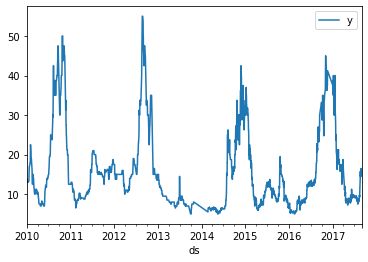

In [541]:
(data1.set_index('ds')).plot()
plt.show()

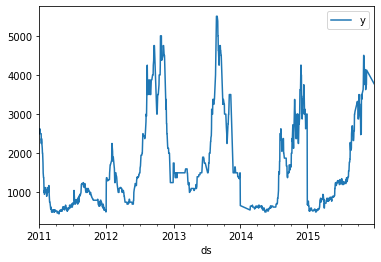

In [542]:
(data2.set_index('ds')).plot()
plt.show()

In [543]:
print("length of 2020 data= ",years[2020].shape)
print("length of 2019 data= ",years[2019].shape)

length of 2020 data=  (244, 1)
length of 2019 data=  (365, 1)


In [544]:
train_data1 = data1[:len(data1['y']) - 244]
test_data1 = data1[len(data1['y']) - 244:]
train_data2 = data2[:len(data2['y'])-365]
test_data2 =data2[len(data2['y'])-365 : ]

In [545]:
temp_data1 = data1.set_index('ds')
temp_data2 = data2.set_index('ds')

In [546]:
# model1 = Prophet(daily_seasonality= True)
model1 = Prophet()
model1.fit(train_data1)
model2 = Prophet()
model2.fit(train_data2)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### EVEN years

In [547]:
# Python
future1 = model1.make_future_dataframe(periods= 244)
future1.tail()

,ds
2795,2017-08-27
2796,2017-08-28
2797,2017-08-29
2798,2017-08-30
2799,2017-08-31


In [548]:
forecast1 = model1.predict(future1)
forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2010-01-01,15.139155,8.111061,21.652129
1,2010-01-02,15.050011,8.552366,22.033195
2,2010-01-03,14.969570,7.698567,22.091210
3,2010-01-04,14.870345,7.768406,21.761358
4,2010-01-05,14.789475,7.935448,22.235080


In [549]:

# Python
# fig11 = model1.plot(forecast1)
forecast1 = forecast1.reset_index()
from fbprophet.plot import plot_plotly, plot_components_plotly
plot_plotly(model1, forecast1)

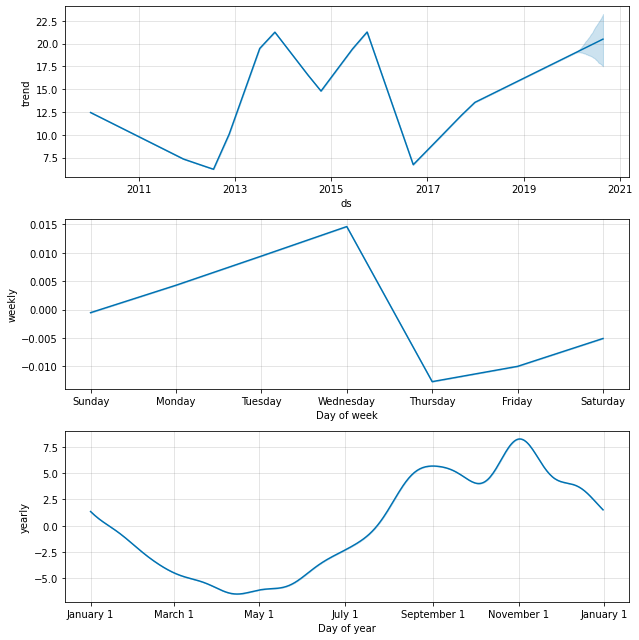

In [493]:
fig12 = model1.plot_components(forecast1)


#### Training and Testing error

/home/siram/anaconda3/lib/python3.7/site-packages/seaborn/relational.py:663: FutureWarning:

This dataframe has a column name that matches the 'value_name' column name of the resultiing Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.



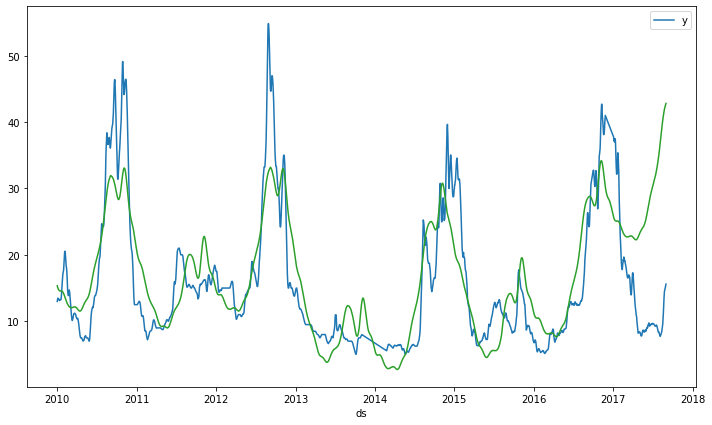

In [526]:
forecast1 = forecast1.set_index('ds')
fig, axes = plt.subplots(figsize= (12,7))
sns.lineplot(data= temp_data1, ax=  axes)
sns.lineplot(data= forecast1['yhat'][train_data_len:])
sns.lineplot(data= forecast1['yhat'][:train_data_len])

In [495]:
from sklearn.metrics import mean_squared_error
from math import sqrt
train_data_len = train_data1.shape[0]
train_rms = sqrt(mean_squared_error(train_data1['y'], forecast1['yhat'][:train_data_len]))
print("ROOT mean squared error on training data= ",train_rms)

ROOT mean squared error on training data=  6.513056074647788


In [496]:
test_data_len = len(forecast1['yhat']) - len(train_data1['y'])
test_rms = sqrt(mean_squared_error(test_data1['y'][:test_data_len], forecast1['yhat'][train_data_len:]))
print("ROOT mean squared error on testing data= ",test_rms)

ROOT mean squared error on testing data=  8.662701177871


In [424]:
test_data1.head(21)

,ds,y
1827,2015-01-02,3767.045455
1828,2015-01-03,3758.522727
1829,2015-01-04,3750.000000
1830,2015-01-05,3625.000000
1831,2015-01-06,3625.000000
1832,2015-01-07,3875.000000
1833,2015-01-08,3500.000000
1834,2015-01-09,4000.000000
1835,2015-01-10,3875.000000
1836,2015-01-11,3750.000000


In [425]:
forecast1['yhat'].tail(21)

ds
2015-08-13    922.129112
2015-08-14    923.715015
2015-08-15    908.841115
2015-08-16    904.202817
2015-08-17    900.630137
2015-08-18    896.306735
2015-08-19    892.769119
2015-08-20    906.073977
2015-08-21    911.198957
2015-08-22    899.812497
2015-08-23    898.548700
2015-08-24    898.178064
2015-08-25    896.827909
2015-08-26    895.982901
2015-08-27    911.653627
2015-08-28    918.778488
2015-08-29    908.994477
2015-08-30    908.912842
2015-08-31    909.290386
2015-09-01    908.250269
2015-09-02    907.282670
Name: yhat, dtype: float64

### ODD years model

In [402]:
# Python
future2 = model2.make_future_dataframe(periods=len(test_data2))
future2.tail()

,ds
1820,2015-12-26
1821,2015-12-27
1822,2015-12-28
1823,2015-12-29
1824,2015-12-30


In [403]:
forecast2 = model2.predict(future2)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2011-01-01,1848.884958,1167.761686,2543.097772
1,2011-01-02,1843.439002,1186.371401,2506.379993
2,2011-01-03,1838.165001,1156.795398,2567.594142
3,2011-01-04,1827.564305,1150.962044,2501.241823
4,2011-01-05,1811.209111,1120.869143,2468.203292


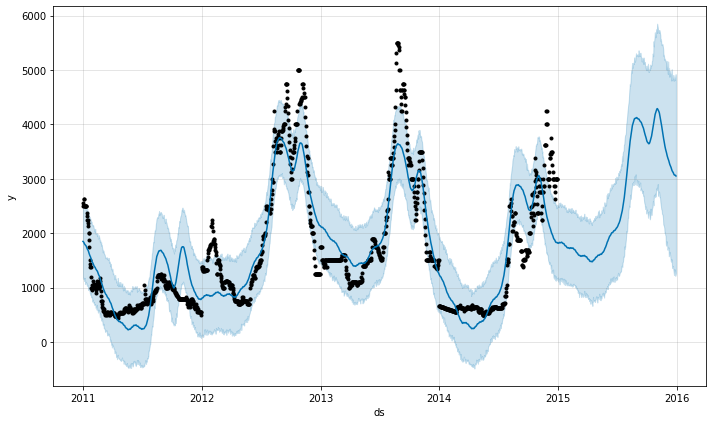

In [404]:
fig21 = model2.plot(forecast2)

/home/siram/anaconda3/lib/python3.7/site-packages/seaborn/relational.py:663: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resultiing Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  x, y, hue, size, style, units, data


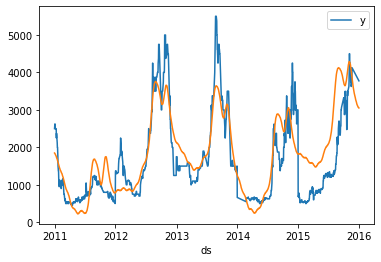

In [409]:
forecast2 = forecast2.set_index('ds')
sns.lineplot(data= temp_data2)
sns.lineplot(data= forecast2['yhat'])

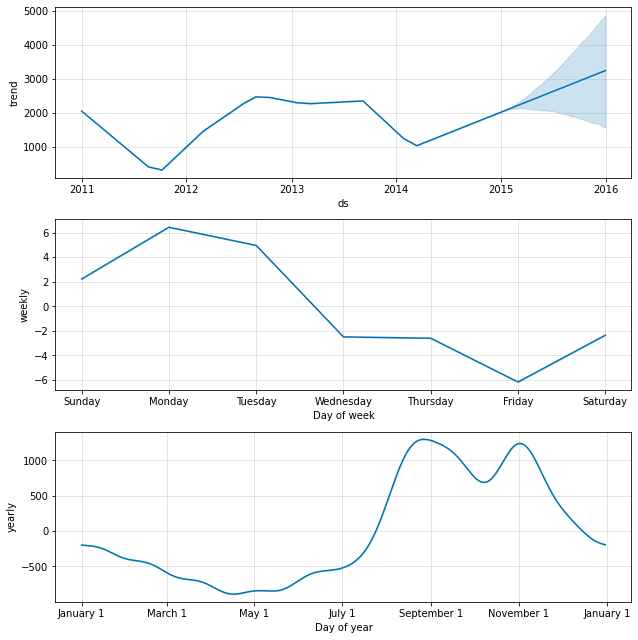

In [406]:
fig22 = model2.plot_components(forecast2)


In [407]:
from sklearn.metrics import mean_squared_error
from math import sqrt

train_data_len2 = train_data2.shape[0]
train_rms2 = sqrt(mean_squared_error(train_data2['y'], forecast2['yhat'][:train_data_len2]))

test_data_len2 = len(forecast2['yhat']) - len(train_data2['y'])
test_rms2 = sqrt(mean_squared_error(test_data2['y'][:test_data_len2], forecast2['yhat'][train_data_len2:]))

print("ROOT mean squared error on training data= ",train_rms2)
print("ROOT mean squared error on testing data= ",test_rms2)

ROOT mean squared error on training data=  532.323850540574
ROOT mean squared error on testing data=  1062.1309343588828


In [408]:
# def make_model(req_years):

- the year breaking methods are not working will beacuse of the discontiuity prduced in the series as the period is not exact 2 years and the + or - shift the total series.

In [301]:
req_years3 = [2010, 2012, 2014, 2016, 2018]
data3 = []
data4 = []
for year in req_years3:
    this_year = years[year].values
    next_year = years[year+1].values
    for i in range(365):
        data3.append((this_year[i] + next_year[i])/2)
        data4.append((this_year[i] - next_year[i])/2)

new_index3 = pd.date_range(start= '2010-1-1', periods= len(data3)).to_list()
df3 = pd.DataFrame(data= data3, index= new_index3)
df4 = pd.DataFrame(data= data4, index= new_index3)
df3 = df3.reset_index()
df4 = df4.reset_index()
df3.columns = ['ds', 'y']
df4.columns = ['ds', 'y']

In [307]:
temp_data3= df3.set_index('ds')
temp_data4= df4.set_index('ds')

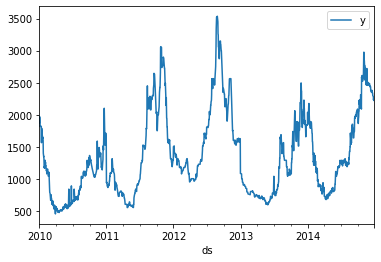

In [308]:
temp_data3.plot()

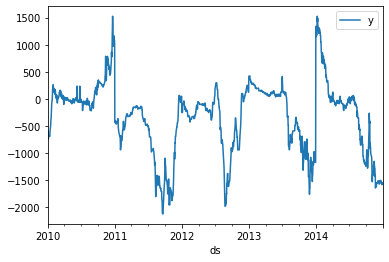

In [309]:
temp_data4.plot()

In [327]:
train_data3 = df3[:len(df3)-364]
test_data3 = df3[len(df3)-364 :]

In [328]:
test_data3.head()

,ds,y
1461,2014-01-01,2037.5
1462,2014-01-02,1850.0
1463,2014-01-03,1962.5
1464,2014-01-04,1925.0
1465,2014-01-05,1950.0


In [358]:
test_data4.head()

,ds,y
1461,2014-01-01,1337.5
1462,2014-01-02,1150.0
1463,2014-01-03,1287.5
1464,2014-01-04,1200.0
1465,2014-01-05,1175.0


In [364]:
forecast3['yhat'][len(train_data3):].head()

1461    1331.850770
1462    1308.803054
1463    1287.410151
1464    1263.724360
1465    1244.513239
Name: yhat, dtype: float64

In [365]:
forecast4['yhat'][len(train_data4):].head()

1461   -461.859148
1462   -482.409959
1463   -509.561812
1464   -540.108725
1465   -566.168319
Name: yhat, dtype: float64

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


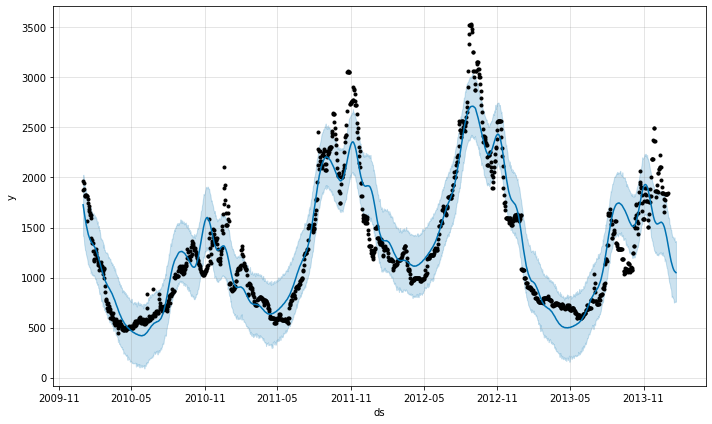

In [329]:
model3  = Prophet()
model3.fit(train_data3)
future3 = model3.make_future_dataframe(periods= 21)
forecast3 = model3.predict(future3)
fig31 = model3.plot(forecast3) 

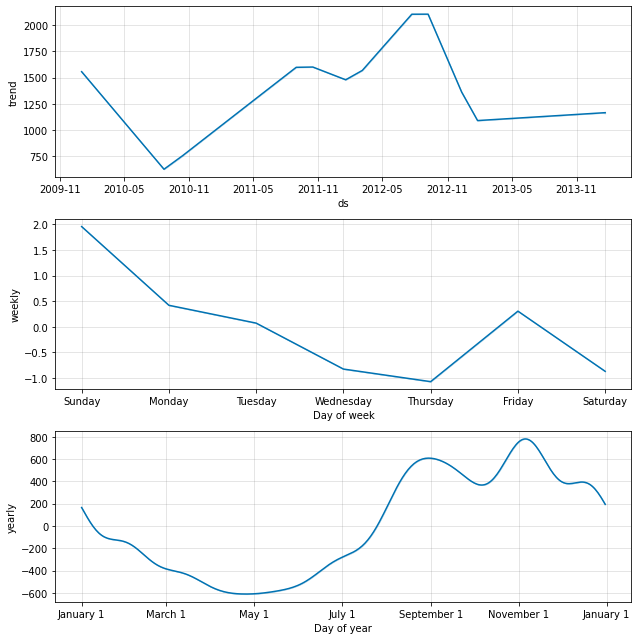

In [330]:
fig32 = model3.plot_components(forecast3)

In [331]:
train_data4 = df4[:len(df4)-364]
test_data4 = df4[len(df4)-364:]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


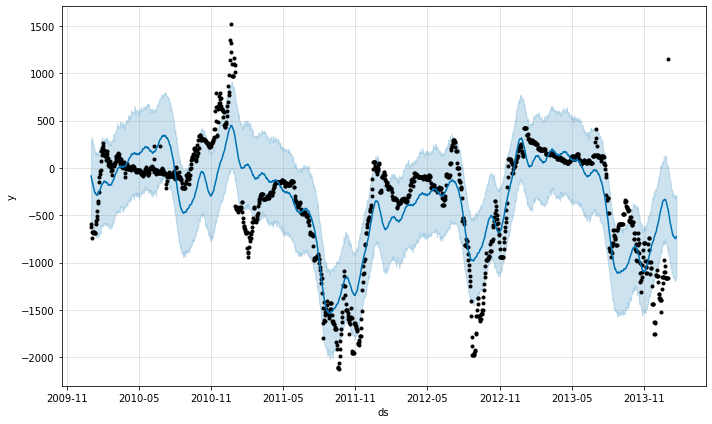

In [332]:
model4  = Prophet()
model4.fit(train_data4)
future4 = model4.make_future_dataframe(periods= 21)
forecast4 = model4.predict(future4)
fig41 = model4.plot(forecast4) 

In [354]:
df3.head()

,ds,y
0,2010-01-01,1875.00
1,2010-01-02,1968.75
2,2010-01-03,1943.75
3,2010-01-04,1887.50
4,2010-01-05,1812.50


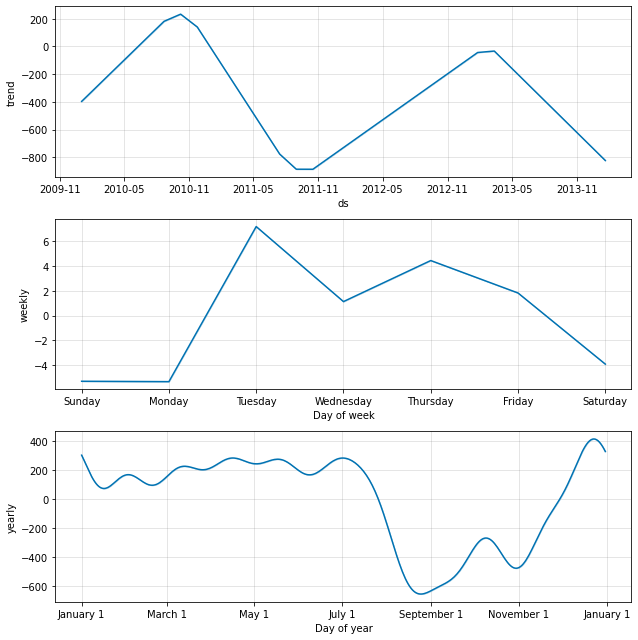

In [333]:
fig42 = model4.plot_components(forecast4) 

In [344]:
y_hat4 = forecast3['yhat'] + forecast4['yhat']
rms = sqrt(mean_squared_error(y_hat4[len(train_data3):], years[2018].values[:21]))
rms

2755.4679485982674

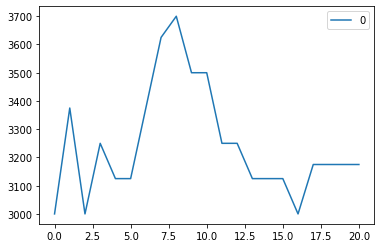

In [348]:
# sns.lineplot(data= y_hat4[len(train_data3):])
sns.lineplot(data= years[2018].values[:21], color= 'red')

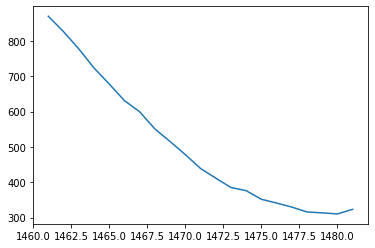

In [350]:
sns.lineplot(data= y_hat4[len(train_data3):])


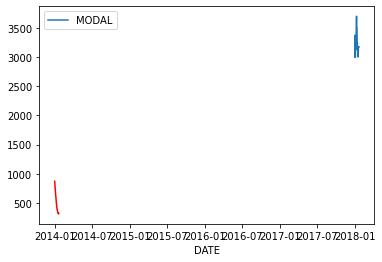

In [431]:
forecast3 = forecast3.set_index('ds')
forecast4 = forecast4.set_index('ds')
y_hat4 = forecast3['yhat'] + forecast4['yhat']
sns.lineplot(data= years[2018][:21])
sns.lineplot(data= y_hat4[len(train_data3):], color= 'red')

In [351]:
y_hat4[len(train_data3):]

1461    869.991622
1462    826.393095
1463    777.848339
1464    723.615634
1465    678.344919
1466    631.252941
1467    599.651435
1468    551.155413
1469    515.381231
1470    478.368163
1471    439.061050
1472    411.727291
1473    385.141492
1474    376.124531
1475    351.763855
1476    341.124341
1477    329.683163
1478    315.825856
1479    313.276525
1480    310.295184
1481    323.228655
Name: yhat, dtype: float64

In [352]:
 years[2018].values[:21]

array([[3000.],
       [3375.],
       [3000.],
       [3250.],
       [3125.],
       [3125.],
       [3375.],
       [3625.],
       [3700.],
       [3500.],
       [3500.],
       [3250.],
       [3250.],
       [3125.],
       [3125.],
       [3125.],
       [3000.],
       [3175.],
       [3175.],
       [3175.],
       [3175.]])